In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson 
from scipy.special import factorial, logsumexp
import statsmodels.api as sm
import matplotx
from multiprocessing import Pool
from time import time
from tqdm import tqdm
plt.style.use(matplotx.styles.aura["dark"])

In [2]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


colors = ["tab:red", "tab:blue"]

In [3]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


number of trials: 290
X shape = (13238, 61)


<Axes: >

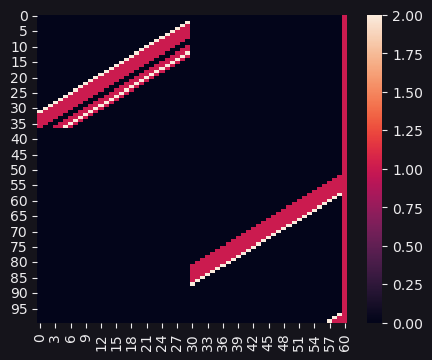

In [4]:
# constructing design matrix with all trials and all neurons
# np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 10
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
trial_id = []
X = []


for trial_idx in trial_indices:
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    trial_length = trial_end - trial_start

    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    lcue_times = data["cueOnset_L"][trial_idx]
    rcue_times = data["cueOnset_R"][trial_idx]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

    X.append(np.hstack((X_sr, X_sl, np.ones((X_sr.shape[0], 1)))))
    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))


trial_id = np.concatenate(trial_id).astype(int)
X = np.vstack(X)
print(f'X shape = {X.shape}')

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(X[:100])

transition matrix: 
[[0.9  0.1 ]
 [0.17 0.83]]


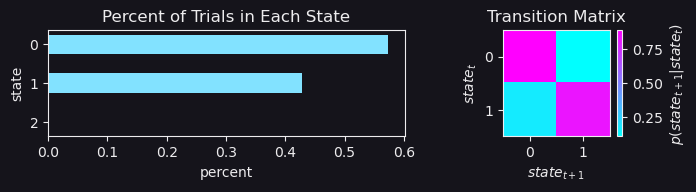

In [5]:
# Generating states for simulation
# np.random.seed(1)
np.random.seed(0)
n_states = 2
t_init = np.array([1.4, 0.7, 0.7])[:n_states]
T_sim = np.array([dirichlet(np.roll(t_init**(n+1), n)).rvs()[0] for n in range(n_states)])
dist_init = np.array([0.8, 0.1, 0.1])[:n_states]
dist_init /= dist_init.sum()
sim_states = np.ones(trial_indices.size).astype(int)
for i in range(sim_states.size):
    if i == 0:
        sim_states[i] = np.random.choice(np.arange(n_states), 1, p=dist_init)
    sim_states[i] = np.random.choice(np.arange(n_states), 1, p=T_sim[sim_states[i-1]])

print(f'transition matrix: \n{np.round(T_sim, 2)}')
fig, axs = plt.subplots(1, 2, figsize=(7, 2), gridspec_kw={'width_ratios': [5, 2]})
_ = axs[0].hist(sim_states, bins=np.arange(-0.5, 2.51, 1), density=True, rwidth=0.5, orientation='horizontal')
axs[0].set_title('Percent of Trials in Each State')
axs[0].set_xlabel('percent')
axs[0].set_ylabel('state')
axs[0].set_ylim(axs[0].get_ylim()[::-1])
im = axs[1].imshow(T_sim, cmap='cool', origin='upper')
plt.colorbar(im, ax=axs[1], label='$p(state_{t+1} | state_t)$')
axs[1].set_title('Transition Matrix')
axs[1].set_ylabel(r'$state_t$')
axs[1].set_xlabel(r'$state_{t+1}$')
plt.tight_layout()

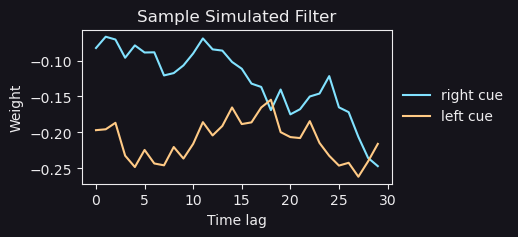

In [6]:
# generating parameters for each state for each neuron
# np.random.seed(0)
n_filters = 2
theta_sim = np.empty((n_states, filt_len*n_filters+1, n_neurons))
for n in range(n_neurons):
    for s in range(n_states):
        for f in range(n_filters):  # 2 filters, right stim, left stim, (no spikes for simulated data)
            for i in range(filt_len):
                if i == 0:
                    theta_sim[s, i+(f * filt_len), n] = np.random.normal(0, 0.1)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
                else:
                    theta_sim[s, i+(f*filt_len), n] = np.random.normal(theta_sim[s, i+(f*filt_len)-1, n], .02)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
        theta_sim[s, -1, n] = np.random.normal(0.15, 0.05) #bias term

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(theta_sim[0, :-1, 1].reshape(2, -1).T, label=['right cue', 'left cue'])
ax.set_title('Sample Simulated Filter')
ax.set_xlabel('Time lag')
ax.set_ylabel('Weight')
plt.legend(bbox_to_anchor=(1.4, 0.7))


(13238, 10)


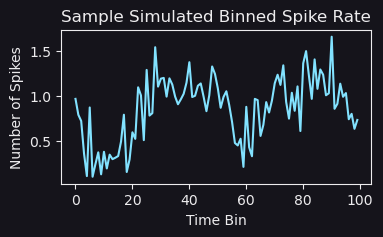

In [16]:
# generating spike rate data
y_sim = []
for trial in np.unique(trial_id):
    x_idx = np.argwhere(trial_id==trial)
    y_sim.append(np.squeeze(X[x_idx] @ theta_sim[sim_states[trial]]))

y_sim = np.exp(np.vstack(y_sim)) + np.random.normal(0, 0.2, size = (X.shape[0], n_neurons))
# y_sim = np.round(y_sim, 2)
print(y_sim.shape)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(y_sim[:100, 0])
ax.set_title('Sample Simulated Binned Spike Rate')
ax.set_xlabel('Time Bin')
ax.set_ylabel('Number of Spikes');


In [18]:
#initial glm with no states to estimate weights
theta_init = np.empty(theta_sim[0].shape)
sta = (X.T @ y_sim) / y_sim.sum()
glms = [None for _ in range(n_neurons)]

for neuron in range(n_neurons):
    glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson())
    glms[neuron] = glm
    a = 0.5 * np.ones(X.shape[1])
    a[-1] = 0
    res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

    w = res.params
    theta_init[:, neuron] = w


100%|██████████| 15/15 [02:04<00:00,  8.29s/it]


finall LL = -0.00038681441712433976


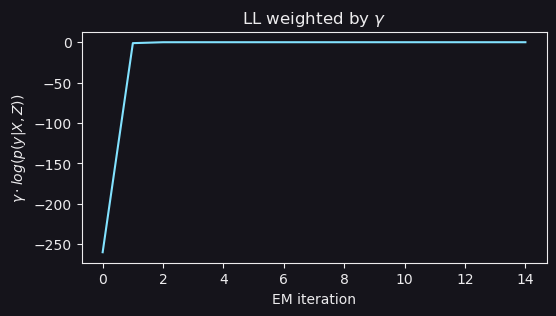

In [23]:
# with functions
n_states = 3
n_trials = trial_indices.size
theta_hmm = np.ones((n_states, X.shape[1], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, .01, size=theta_hmm.shape)
t_init = np.array([5, 1, 1, 1, 1, 1])
# placing higher bias on self-transition
T = np.array([dirichlet(np.roll(t_init[:n_states], n)).rvs()[0] for n in range(n_states)])
T = np.log(T)
pi = np.log(np.ones(n_states)) - np.log(n_states)

xi = np.empty((n_trials-1, n_states, n_states))
scale = np.empty(n_trials)
total_ll = []



def get_poiss_ll(X, y, theta):
    v = X @ theta
    r = np.exp(v)
    ll = y * np.log(r) - r
    ll = ll.sum(axis=(1,2))
    return ll - logsumexp(ll)

def forward(X, y, theta, T, pi, trial_id):
    n_trials = np.unique(trial_id).size
    n_states = theta.shape[0]
    alpha = np.empty((n_states, n_trials))
    predict = np.empty(alpha.shape)
    loglikeli = np.empty(alpha.shape)

    for t in range(n_trials):
        x_idx = np.argwhere(trial_id==t).squeeze()
        # predict
        if t == 0:
            predict[:, t] = pi
        else:
            pred = []
            for tran in T.T:
                pred.append(logsumexp(tran + alpha[:, t-1]))
            predict[:, t] = np.array(pred)

        loglikeli[:, t] = get_poiss_ll(X[x_idx], y[x_idx], theta_hmm)
        # update
        update = loglikeli[:, t] + predict[:, t]
        scale[t] = logsumexp(update)
        update -= scale[t]
        alpha[:, t] = update

    return alpha, loglikeli, scale, predict


for _ in tqdm(range(15)):
    
    alpha, loglikeli, scale, predict = forward(X, y_sim, theta_hmm, T, pi, trial_id)

    beta = np.empty(alpha.shape)
    beta[:, -1] = 0  # in log form
    for t in range(n_trials-2, -1, -1):
        b_up = []
        for tran in T:
            beta_update = tran + beta[:, t+1] + loglikeli[:, t+1]
            b_up.append(logsumexp(beta_update))
        beta[:, t] = np.array(b_up) - scale[t+1]
    gamma = alpha + beta
    gamma -= logsumexp(gamma, axis=0) 

    total_ll.append((np.exp(gamma) * loglikeli).sum())


    for t in range(0, n_trials-1):
        for s1 in range(n_states):
            for s2 in range(n_states):
                xi[t, s1, s2] = T[s1, s2] + alpha[s1, t] + loglikeli[s2, t+1] + beta[s2, t+1]

        xi[t] -= logsumexp(xi[t])
    
    T = logsumexp(xi, axis=0)
    T -= logsumexp(T, axis=1)[:, None]

    _, trial_counts = np.unique(trial_id, return_counts=True)
    pi = gamma[:, 0]

    # maximization
    for s in range(n_states):
        for neuron in range(n_neurons):
            weights = np.repeat(np.exp(gamma[s]), trial_counts)
            glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson(), freq_weights=weights)
            # can greatly effect outcome. too high on simulated data made it fail, basically comes down to noise level of data
            # higher noise ---> set alpha to be higher
            a = .01 * np.ones(X.shape[1])  
            a[-1] = 0
            res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

            w = res.params
            theta_hmm[s, :, neuron] = w

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(np.array(total_ll))
ax.set_title(r'LL weighted by $\gamma$')
ax.set_xlabel('EM iteration')
ax.set_ylabel(r'$\gamma \cdot log(p(y | X, Z))$');
print(f'finall LL = {total_ll[-1]}')

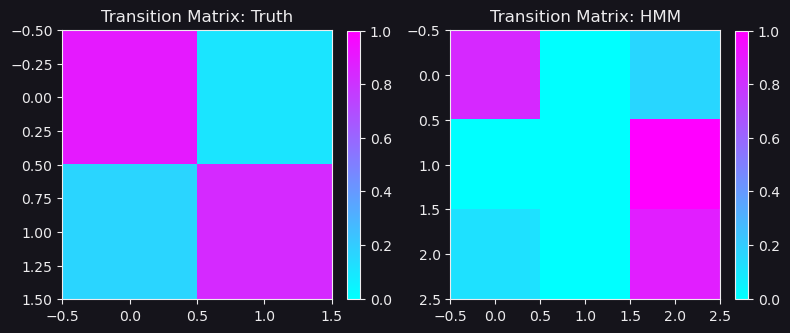

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im = axs[0].imshow(T_sim, cmap='cool', vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0], fraction = 0.045)
axs[0].set_title('Transition Matrix: Truth')
im = axs[1].imshow(np.exp(T), cmap='cool', vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1], fraction = 0.045)
axs[1].set_title('Transition Matrix: HMM')
plt.tight_layout()

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency
df = pd.DataFrame(np.concatenate((np.argmax(gamma, axis=0)[:, None], sim_states[:, None]), axis=1), columns = ['pred', 'truth'])
CrosstabResult=pd.crosstab(index=df['pred'],columns=df['truth'])
print(CrosstabResult)


truth    0    1
pred           
0        0  124
2      166    0


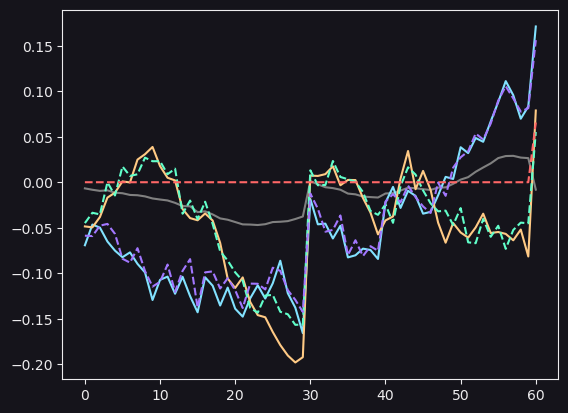

In [26]:
plt.plot(theta_init[:, 0], 'grey')
# for s in range(n_states):
    # plt.plot(theta_sim[s, :, 0], label=f'state: {s}')
    # plt.plot(theta_hmm[s, :, 0], '--')
plt.plot(theta_sim[:, :, 0].T)
plt.plot(theta_hmm[:, :, 0].T, '--')
# plt.legend()


(array([[166.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 124.],
        [290.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [124.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 166.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

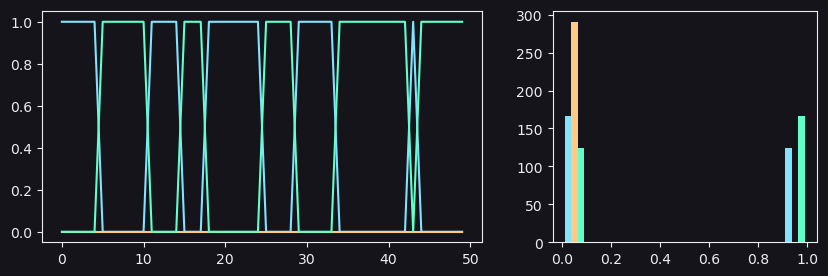

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': (5, 3)})
axs[0].plot(np.exp(gamma.T)[:50])
axs[1].hist(np.exp(gamma.T))

<Axes: >

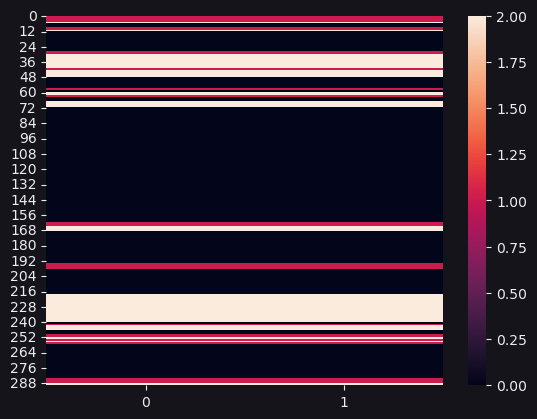

In [78]:
fig, ax = plt.subplots()
st_org = sim_states[:, None].copy()
st_org[sim_states==0] = 2
st_org[sim_states==1] = 1
st_org[sim_states==2] = 0
sns.heatmap(np.concatenate((np.exp(gamma).argmax(axis=0)[:, None], st_org), axis=1))

In [155]:
np.random.seed(0)
n_states = 3
n_trials = trial_indices.size
theta_hmm = np.ones((n_states, X.shape[1], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, .1, size=theta_hmm.shape)
# theta_hmm = theta_sim
t_init = np.array([2, 1, 1])[:n_states]
# placing higher bias on self-transition
T = np.array([dirichlet(np.roll(t_init, n)).rvs()[0] for n in range(n_states)])

pi = np.ones(n_states) / n_states
alpha = np.empty((n_states, n_trials))
beta = np.empty(alpha.shape)
beta[:, -1] = 0
predict = np.empty(alpha.shape)
loglikeli = np.empty(alpha.shape)
xi = np.empty((n_trials-1, n_states, n_states))
scale = np.empty(n_trials)



for _ in range(20):
    # print(theta_hmm[0, :, 0])
    # expectation step:
    for t in range(0, n_trials):
        x_idx = np.argwhere(trial_id==t).squeeze()


        # predict
        if t == 0:
            predict[:, t] = pi
        else:      
            predict[:, t] = T.T @ alpha[:, t-1]


        
        v = X[x_idx] @ theta_hmm
        r = np.exp(v)
        ll = y_sim[x_idx] * np.log(r) - r
        # ll -= logsumexp(ll, axis=0)
        ll = ll.sum(axis=(1,2))
        loglikeli[:, t] = ll - logsumexp(ll)

        # update
        update = np.exp(loglikeli[:, t]) * predict[:, t]
        scale[t] = update.sum()
        update /= scale[t]
        alpha[:, t] = update
        # print(np.exp(predict[:, t]))
    
    

    beta = np.empty(alpha.shape)
    beta[:, -1] = 1  
    for t in range(n_trials-2, -1, -1):
        
        beta[:, t] = T @ (beta[:, t+1] * np.exp(loglikeli[:, t+1]))
        beta[:, t] /= scale[t+1]

    gamma = alpha * beta
    gamma /= np.sum(gamma, axis=0) 

    # total_ll.append((loglikeli*np.exp(gamma)).sum())

    for t in range(0, n_trials-1):

        # for s1 in range(n_states):
        #     for s2 in range(n_states):
        #         xi[t, s1, s2] = T[s1, s2] + alpha[s1, t] + loglikeli[s2, t+1] + beta[s2, t+1]

        # xi[t] -= logsumexp(xi[t])

        xi[t] = T * (alpha[:, t] @ (beta[:, t+1] * np.exp(loglikeli[:, t+1])).T)
        # print(xi[t])
        xi[t] /= np.sum(xi[t])  #should this be normalized along 1 axis or the entire matrix??
        # print(xi[t]/np.sum(xi[t]))
    
    T = np.sum(xi, axis=0)
    T /= np.sum(T, axis=1)[:, None]
    # T /= np.sum(gamma, axis=1)[:, None]
    print(T)
    # T = np.exp(T)
    _, trial_counts = np.unique(trial_id, return_counts=True)
    pi = gamma[:, 0]

    # print(gamma.T)
    # maximization
    for s in range(n_states):
        for neuron in range(n_neurons):
            weights = np.repeat(gamma[s], trial_counts)
            glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson(), freq_weights=weights)

            a = .001 * np.ones(X.shape[1])
            a[-1] = 0
            res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)
            # res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
            w = res.params
            theta_hmm[s, :, neuron] = w
    

[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.25567887 0.06659027]
 [0.21101999 0.27489316 0.51408685]
 [0.50009046 0.11522688 0.38468265]]
[[0.67773086 0.2556

array([[7.77324437e-01, 9.11810236e-02, 1.31494539e-01],
       [3.40560940e-01, 4.73503201e-01, 1.85935859e-01],
       [5.72183984e-02, 1.33402456e-04, 9.42648199e-01]])

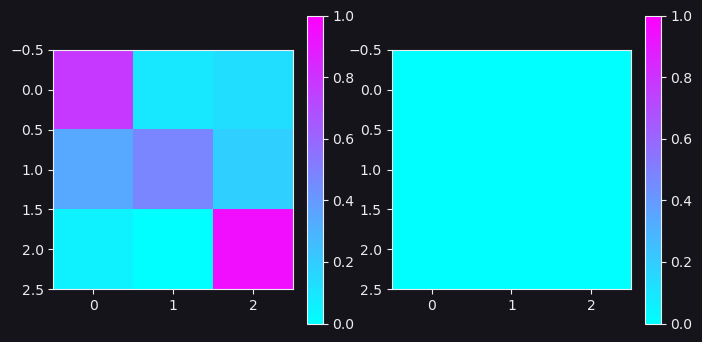

In [160]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im = axs[0].imshow(T_sim, cmap='cool', vmin = 0, vmax = 1)
plt.colorbar(im, ax=axs[0], fraction = 0.1)

im = axs[1].imshow(T, cmap='cool', vmin=0, vmax=1)

plt.colorbar(im, ax=axs[1], fraction = 0.1)
T_sim

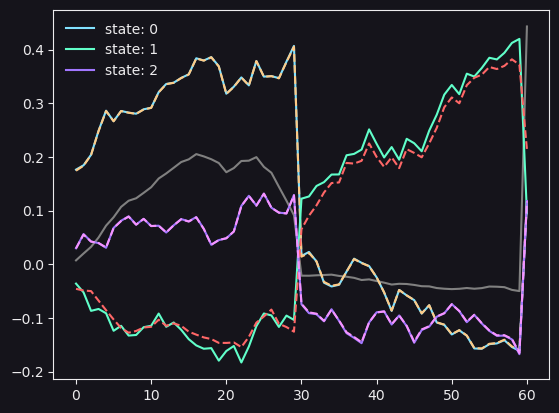

In [174]:
plt.plot(theta_init[:, 0], 'grey')
for s in range(n_states):
    plt.plot(theta_sim[s, :, 0], label=f'state: {s}')
    plt.plot(theta_hmm[s, :, 0], '--')

plt.legend()

### actual data

In [ ]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 50
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)

trial_id = []  # this will keep track of each trial in the design matrix (since each trial spans multiple rows)
for i, neuron in enumerate(neuron_idx):
    X = []
    y = []

    for trial_idx in trial_indices:
        trial_start = data["trialStart"][trial_idx]
        trial_end = data["trialEnd"][trial_idx]
        trial_length = trial_end - trial_start
        spikes = data["spikes"][neuron]
        spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
        keyframes = data["keyFrames"][trial_idx]
        keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
        lcue_times = data["cueOnset_L"][trial_idx]
        rcue_times = data["cueOnset_R"][trial_idx]

        bins = np.arange(0, trial_length, bin_size)
        bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

        binned_stimr, _ = np.histogram(rcue_times, bins)
        binned_stiml, _ = np.histogram(lcue_times, bins)
        binned_spikes, _ = np.histogram(spikes - trial_start, bins)
        binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

        padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
        X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
        padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
        X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
        padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
        X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

        padded_spikes = np.pad(
            binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0)
        )
        X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

        X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
        y.append(binned_spikes[:, np.newaxis])
        if i == 0:
            trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    X_all.append(np.vstack(X))
    y_all.append(np.vstack(y))

trial_id = np.concatenate(trial_id)
X_all = np.array(X_all)
y_all = np.array(y_all)

In [ ]:
# def glm_fit(d):
#     x, y = d
#     glm = sm.GLM(endog=y, exog=x, family=sm.families.Poisson())

#     res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
#     return res.params

# input = tuple(zip(X_all, y_all))

# pool = Pool(10)

# w_initial = pool.map(glm_fit, input)